# Aprendizaje de Máquina 1
## Trabajo Práctico Individual

### Alumno: Fux, Santiago

## Enunciado

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset que contiene las siguientes columnas:
* Step: representa una unidad de tiempo donde 1 step equivale a 1 hora
* type: tipo de transacción en línea
* amount: el importe de la transacción
* nameOrig: cliente que inicia la transacción
* oldbalanceOrg: saldo antes de la transacción
* newbalanceOrig: saldo después de la transacción
* nameDest: destinatario de la transacción
* oldbalanceDest: saldo inicial del destinatario antes de la transacción
* newbalanceDest: el nuevo saldo del destinatario después de la transacción
* isFraud: transacción fraudulenta

Utilizando los modelos de clasificación vistos hasta el momento generar un notebook que permita de ser posible resolver el problema que nos está planteando el cliente.  
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

## Importación de las librerías utilizadas

In [1]:
# Importamos las librerias necesarias para interactuar con el dataset.
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Importamos las bibliotecas que usaremos
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.model_selection import train_test_split

#scores
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


## Carga de datos

Obtenemos los datos desde un archivo csv a través de la librería Panda. Los datos se cargan como un dataset y se imprimen los primeros valores

In [2]:
# cargamos el dataset desde un csv
DATASET_PATH = 'data/'
DATASET_NAME = 'PS_20174392719_1491204439457_log.csv'

df = pd.read_csv(DATASET_PATH + DATASET_NAME)
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Análisis de datos

Observamos los valores característicos de cada uno de los features y sus tipos de datos

In [3]:
# visualizamos las métricas de cada feature
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
#visualizamos los tipos de cada feature
df.columns, df.dtypes

(Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
        'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
        'isFlaggedFraud'],
       dtype='object'),
 step                int64
 type               object
 amount            float64
 nameOrig           object
 oldbalanceOrg     float64
 newbalanceOrig    float64
 nameDest           object
 oldbalanceDest    float64
 newbalanceDest    float64
 isFraud             int64
 isFlaggedFraud      int64
 dtype: object)

Graficamos las distribuciones de los features

In [5]:
# funcion para plotear las distribuciones de los atributos
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=10, ylabelsize=10,figsize=(18,18))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout
    plt.show()

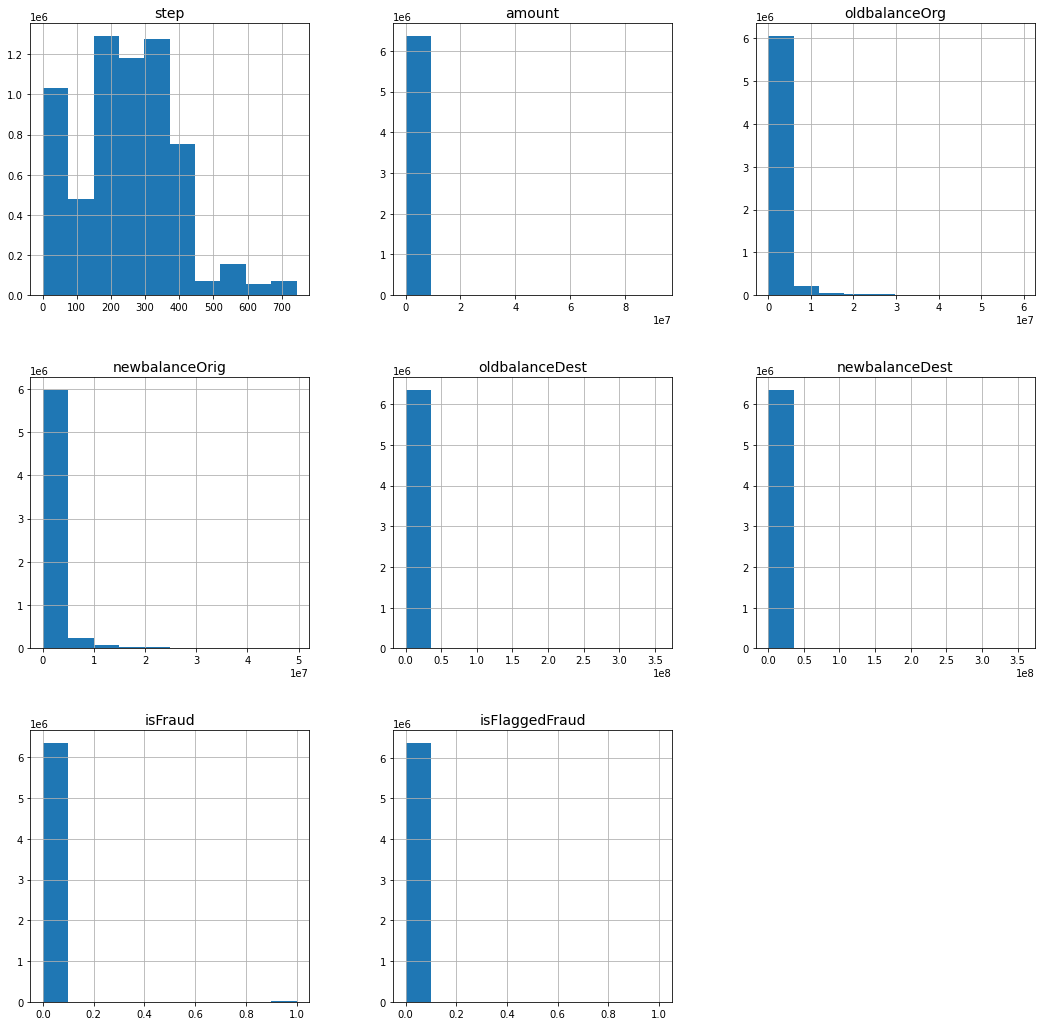

In [6]:
#imprimo distribuciones 
display_dataset_distributions(df)

### Ingeniería de datos

En esta sección vamos a agregar nuevos features en base a las variables originales

#### Variable type

In [7]:
# variable type es categórica
total_items = len(df)
df['type'].unique(), df['type'].value_counts()

(array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
       dtype=object),
 CASH_OUT    2237500
 PAYMENT     2151495
 CASH_IN     1399284
 TRANSFER     532909
 DEBIT         41432
 Name: type, dtype: int64)

In [8]:
#convierto a freq encoding
type_freq_map = (df['type'].value_counts() / total_items).to_dict()
df['typeFreq'] = df['type'].apply(lambda x: type_freq_map[x])

df['typeFreq'].unique()

array([0.33814608, 0.08375622, 0.35166331, 0.00651178, 0.21992261])

#### Variable nameOrig

In [9]:
# verifico cuántos tipos de origenes hay
num_categories = len(df['nameOrig'].unique())
print(f'Categorias: {num_categories}, Total={total_items}')

Categorias: 6353307, Total=6362620


__Conclusión__: se decide descartar esta categoría  

#### Variable namedest

In [10]:
# verifico cuantos tipos de origenes hay
num_categories = len(df['nameDest'].unique())
print(f'Categorias: {num_categories}, Total={total_items}')

Categorias: 2722362, Total=6362620


__Conclusión__: se decide descartar esta categoría  

### Verficación de los datos nulos

Imprimo la cantidad de datos nulos por categoría

In [11]:
col_names = df.columns

for i, col in enumerate(col_names):
  print(f'{col} Nulos/Total = {df[col].isnull().sum()}/{df[col].size}')

step Nulos/Total = 0/6362620
type Nulos/Total = 0/6362620
amount Nulos/Total = 0/6362620
nameOrig Nulos/Total = 0/6362620
oldbalanceOrg Nulos/Total = 0/6362620
newbalanceOrig Nulos/Total = 0/6362620
nameDest Nulos/Total = 0/6362620
oldbalanceDest Nulos/Total = 0/6362620
newbalanceDest Nulos/Total = 0/6362620
isFraud Nulos/Total = 0/6362620
isFlaggedFraud Nulos/Total = 0/6362620
typeFreq Nulos/Total = 0/6362620


### Desbalance de la variable objetivo

In [12]:
# Verifico proporción de la categoría de la variable objetivo
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Las categorías están super desbalanceadas (99%-1%) por lo que tengo que considerar para obtener mejores resultados los conceptos de:
* Undersampling
* Oversampling

## Distribución del dataset del modelo

Hago una distribución de los datasets de train y test

In [13]:
# Particionamos en train y test
train_ratio = 0.7
test_ratio = 0.3

# descarto los features nameOrig y nameDest
# me quedo con typeFreq en lugar de type
feature_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeFreq']


## Funciones útiles a implementar para regresión lineal

In [14]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1])
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    print(f'Precision:{precision}, Recall: {recall}:')
    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues')
    

## Regresión lineal con datos desbalanceados

Implementamos regresión lineal sin balancear la variable de salida con ningún mecanismo. El entrenamiento de esta forma no es aconsejado habitualmente dado que se establecen muy pocos casos positivos (donde existe fraude). De todos modos se aplica __stratify__ para hacer una distribución pareja de los casos en los datasets de train y test.

In [15]:
# obtengo los datos filtrados pero sin escalar repartidos de forma pareja entre train y test
X_raw = df[feature_cols]
y_raw = df['isFraud']

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, stratify=y_raw, random_state=1)

In [16]:
#verifico cantidad de ejemplos en cada uno de los tests
y_raw_train_fraud_percentage = y_raw_train.value_counts(normalize=True)
y_raw_test_fraud_percentage = y_raw_test.value_counts(normalize=True)

print(f'Porcentaje de fraudes en train: \n{y_raw_train_fraud_percentage}%')
print(f'Porcetaje de fraudes en test: \n{y_raw_test_fraud_percentage}%')

Porcentaje de fraudes en train: 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64%
Porcetaje de fraudes en test: 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.86      0.49      0.62      2053

    accuracy                           1.00   1590655
   macro avg       0.93      0.74      0.81   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.9737
Area bajo la curva Precision-Recall: 0.6419
Precision:[0.00130664 0.001306   0.001306   ... 1.         1.         1.        ], Recall: [1.         0.99951291 0.99951291 ... 0.13395032 0.13248904 0.        ]:


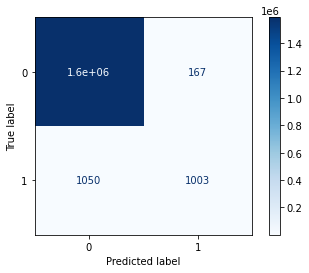

In [17]:
logistic_regression_report(X_raw_train, X_raw_test, y_raw_train, y_raw_test)

## Regresión lineal con datos balanceados (undersampling)

In [18]:
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority')

X_us_train,y_us_train = undersampler.fit_resample(X_raw_train,y_raw_train)

print('Composición del training set:')
print(y_us_train.value_counts())

print('\nComposición del test set:')
print(y_raw_test.value_counts())

Composición del training set:
0    6160
1    6160
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.89      0.06      2053

    accuracy                           0.96   1590655
   macro avg       0.52      0.93      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655

Area bajo la curva ROC: 0.9763
Area bajo la curva Precision-Recall: 0.5661
Precision:[0.00130867 0.00130804 0.00130804 ... 0.97765363 0.97740113 1.        ], Recall: [1.         0.99951291 0.99951291 ... 0.25572333 0.25280078 0.        ]:


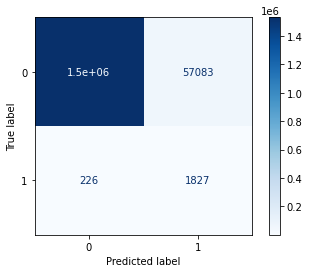

In [19]:
logistic_regression_report(X_us_train, X_raw_test, y_us_train, y_raw_test)


## Regresión lineal con datos balanceados (oversampling)

In [20]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy='minority')

X_os_train, y_os_train = oversampler.fit_resample(X_raw_train,y_raw_train)

print('Composición del training set:')
print(y_os_train.value_counts())

print('\nComposición del test set:')
print(y_raw_test.value_counts())

Composición del training set:
0    4765805
1    4765805
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.89      0.06      2053

    accuracy                           0.96   1590655
   macro avg       0.51      0.93      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655

Area bajo la curva ROC: 0.9763
Area bajo la curva Precision-Recall: 0.5583
Precision:[0.00131518 0.00131454 0.00131454 ... 0.97661871 0.97992701 1.        ], Recall: [1.         0.99951291 0.99951291 ... 0.26449099 0.26156844 0.        ]:


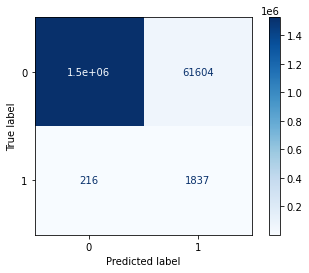

In [21]:
logistic_regression_report(X_os_train, X_raw_test, y_os_train, y_raw_test)


## Random Forest 

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
total_trees = 100 # number of trees
max_depth = 10

rf = RandomForestClassifier(n_estimators = total_trees, max_depth = max_depth, random_state=0)

In [24]:
rf.fit(X_raw_train, y_raw_train)
# Utilizamos el método de predicción en los datos de prueba
y_rf_pred = rf.predict(X_raw_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      0.72      0.84      2053

    accuracy                           1.00   1590655
   macro avg       1.00      0.86      0.92   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.8609
Area bajo la curva Precision-Recall: 0.8601


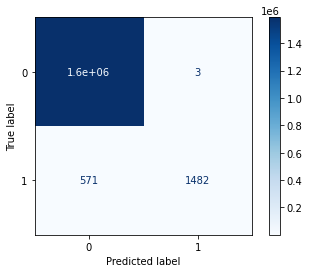

In [25]:
print(classification_report(y_raw_test,y_rf_pred))
print('Area bajo la curva ROC:',np.round(roc_auc_score(y_raw_test,y_rf_pred),4))
rf_precision, rf_recall, rf_threshold=precision_recall_curve(y_raw_test, y_rf_pred)
print('Area bajo la curva Precision-Recall:',np.round(auc(rf_recall,rf_precision),4))
plot_confusion_matrix(rf, X_raw_test, y_raw_test,cmap='Blues')

<BarContainer object of 7 artists>

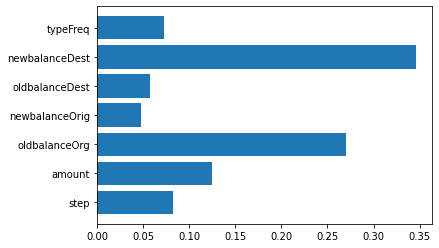

In [26]:
#grafico los features segun su importancia
plt.barh(X_raw_train.columns, rf.feature_importances_)

## SVM

In [27]:
from sklearn.svm import LinearSVC


In [28]:

svm_model = LinearSVC(random_state=23, tol=1e-5,max_iter=5000)


In [29]:
# fit model
#svm_model.fit(X_raw_train_scaled, y_raw_train)

In [30]:
# print("Score the X-train with Y-train is : ", svm_model.score(X_raw_train_scaled, y_raw_train))
# print("Score the X-test  with Y-test  is : ", svm_model.score(X_raw_test_scaled, y_raw_test))

## AutomML

A continuación implementamos pyCaret para que analice cuáles son los mejores modelos que performan para este dataset.

In [31]:
#importo librerias
from pycaret.classification import *
from pycaret.datasets import get_data

In [32]:

df_automl = df[feature_cols]
df_automl['isFraud'] = df['isFraud']
clf1 = setup(df_automl, target = 'isFraud', log_experiment = True, experiment_name = 'ml_tp1', use_gpu=False, silent=True)

,Description,Value
0,session_id,5599
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6362620, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


2022/08/18 22:41:48 INFO mlflow.tracking.fluent: Experiment with name 'ml_tp1' does not exist. Creating a new experiment.


In [33]:
# model training
best_model = compare_models() 

IntProgress(value=0, description='Processing: ', max=74)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:41:49
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,K Neighbors Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9981,0.5281,0.0715,0.1148,0.0881,0.0872,0.0896,8.4480


## Conclusiones

A continuación se detallan los resultados obtenidos para cada uno de los métodos:

| Modelo      | Verdaderos Negativos | Verdaderos positivos | Falsos negativos | Falsos positivos | Notas |
| ----------- | ----------- |-------|----------|---|---|
| Logistic Reg desbalanceado| 1.6e+06 |  1003| 1050 | 167| |
| Logistic Reg undersampling | 1.5e+06| 1841| 212| 60775 | |
| Logistic Reg oversampling | 1.5e+06| 1837| 216| 61604||
| Random Forest | 1.6e+06| 1482| 571| 3||
| SVM | --| --| --| -- |No se logró converger en el intervalo establecido |


En las diferentes matrices de confusión se pueden ver que los valores de TN (verdaderos negativos, es decir, que no son fraudes y no se detecaron como fraudes) siempre es muy alta, por lo que tiende a distorsionar el índice __accuracy__.  
El valor de falso negativo se corresponde a un __verdadero fraude que no es detectado por el modelo__. Este sí es el peor de todos los casos posibles dado que el sistema no pudo identificar con éxito una transacción inválida.

$$ accuracy = {(TP + TN)\over(TP+TN+FP+FN)} $$
$$ recall = {TP\over(TP+FN)} $$
$$ precision = {TP\over(TP+FP)} $$



| Modelo      | Accuracy | Precision | Recall | Notas |
| ----------- | ----------- |-------|----------|---|
| Logistic Reg desbalanceado| 0.99 | 0.8572 | 0.4885| |
| Logistic Reg undersampling | 0.96| 0.0294| 0.8967 | |
| Logistic Reg oversampling | 0.96| 0.0289| 0.8947||
| Random Forest | 0.99| 0.9979| 0.7218||
| SVM | --| --| --| -- |No se logró converger en el intervalo establecido |



En base al concepto anterior, se concluye que los mejores resultados fueron obtenidos con __Logistic regression con y sin undersampling__ donde el recall es mayor si bien han perdido precisión notoriamente respecto de los otros modelos.

